# Accompaniment

In [1]:
ts = 0.9
rs = 42

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [7]:
df_acc = pd.read_csv('Data_Accompaniment_Only_30s_Overlapping.csv')
df_acc['song'] = df_acc['filename'].apply(lambda name: int(name[5:8]))
# df_acc = df_acc[df_acc['label'] != 3]
# display(df_acc.head())
# display(df_acc.info())
features = df_acc.drop(columns = ['filename', 'label'])
# display(features.describe())

gss = GroupShuffleSplit(n_splits=1, train_size=ts, random_state=rs)

generator = gss.split(X = features, y = df_acc['label'], groups =  df_acc['song'])
split_data = generator.__next__()
# print(split_data)
X_train_song = features.iloc[split_data[0]]
df_acc_train = X_train_song
X_test_song = features.iloc[split_data[1]]
y_train = df_acc['label'].iloc[split_data[0]]
y_test = df_acc['label'].iloc[split_data[1]]

# display(X_train_song, X_test_song, y_train, y_test)

X_train = X_train_song.drop('song', axis = 1)
X_test = X_test_song.drop('song', axis = 1)

#####Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_test_acc = pd.DataFrame(X_test, index=y_test.index)

#SVM Model
model_acc_svm = SVC(kernel = 'rbf', C = 0.3, probability = True)
model_acc_svm.fit(X_train, y_train)
y_pred = model_acc_svm.predict(X_test)
y_pred_acc_svm = y_pred
y_test_acc_svm = y_test
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

###############################################  Analyse Misclassifications

results = pd.DataFrame([])
results['y_test'] = y_test
results['y_pred'] = y_pred
results = pd.concat([results, X_test_song['song']], axis = 1)
results_grouped = results.groupby(['song', 'y_pred']).count()

incorrect = results[results['y_test'] != results['y_pred']]['song'].value_counts()
total = results['song'].value_counts().loc[results[results['y_test'] != results['y_pred']]['song'].value_counts().index]
percent_wrong = ((incorrect/total).sort_values(ascending = False) * 100).round(2)

misclassified = pd.DataFrame([])
misclassified['total'] = total
misclassified['incorrect'] = incorrect
misclassified['percent_wrong'] = percent_wrong
misclassified.sort_values(by = 'percent_wrong', ascending = False, inplace = True)
misclassified['1'] = results_grouped.xs(1, level = 1)
misclassified['2'] = results_grouped.xs(2, level = 1)
misclassified['3'] = results_grouped.xs(3, level = 1)
misclassified['real_genre'] = pd.Series(data = misclassified.index, index = misclassified.index).apply(lambda x: x//100)
misclassified['predicted_genre'] = misclassified[['1','2','3']].T.idxmax().astype(int)
misclassified.fillna(value = 0, inplace = True)
misclassified[['1','2','3']] = misclassified[['1','2','3']].astype(int)
misclassified['classification'] = misclassified['real_genre'] == misclassified['predicted_genre']
display(misclassified)
#index gives the song ID
mis_acc = misclassified.copy()
mis_acc_r = misclassified.copy()

misclassified_songs = misclassified.loc[misclassified['classification'] == False]
# display(misclassified_songs)

print('Total no. of songs in test data: ', X_test_song['song'].nunique())
print('No. of songs in which at least 1 excerpt is misclassified: ', len(misclassified.index.values))
print('No. of songs which are misclassified: ', len(misclassified_songs))

              precision    recall  f1-score   support

           1       0.36      0.27      0.31        88
           2       0.58      0.53      0.55       141
           3       0.55      0.77      0.64        86

    accuracy                           0.52       315
   macro avg       0.50      0.52      0.50       315
weighted avg       0.51      0.52      0.51       315

[[24 42 22]
 [35 75 31]
 [ 7 13 66]]


,total,incorrect,percent_wrong,1,2,3,real_genre,predicted_genre,classification
137,20,19,95.00,1,19,0,1,2,False
120,17,16,94.12,1,16,0,1,2,False
203,19,17,89.47,17,2,0,2,1,False
213,25,21,84.00,7,4,14,2,3,False
241,22,18,81.82,1,4,17,2,3,False
146,18,13,72.22,5,3,10,1,3,False
116,18,13,72.22,5,1,12,1,3,False
347,19,10,52.63,2,8,9,3,3,True
233,18,8,44.44,8,10,0,2,2,True
304,21,9,42.86,4,5,12,3,3,True


Total no. of songs in test data:  16
No. of songs in which at least 1 excerpt is misclassified:  13
No. of songs which are misclassified:  7


In [12]:
display(X_train_song, df_acc)

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
0,0.318607,0.030058,1753.256351,1856.478200,3216.047220,0.033327,-384.10440,159.57564,-13.533934,4.156868,...,-11.851375,-5.863056,-5.207622,0.932212,-6.881288,-14.545475,-7.373341,-9.856986,-13.701583,101
1,0.290616,0.031881,1369.296778,1639.685552,2508.734830,0.033723,-357.28550,169.40370,-16.718987,2.567938,...,-8.825030,-4.282399,-6.342405,1.338892,-5.794384,-16.619617,-9.848108,-9.580418,-13.464499,101
2,0.283137,0.037742,1367.873196,1571.712453,2512.843139,0.035310,-349.64175,171.26851,-24.003340,-1.559505,...,-10.624104,-5.974859,-7.170052,0.050079,-6.865687,-17.335167,-10.391975,-8.680845,-12.996750,101
3,0.286401,0.041276,1258.238004,1454.532280,2299.361096,0.033998,-346.43954,180.62689,-17.162390,-2.606062,...,-6.824731,-4.221506,-6.889385,2.207033,-4.634343,-15.978193,-6.844511,-6.314038,-13.830784,101
4,0.296295,0.037778,1189.871773,1450.672881,2089.587365,0.031380,-358.20460,179.68703,-7.887644,-5.116406,...,-8.114536,-6.268031,-8.443713,1.080688,-6.333513,-17.583400,-7.645139,-7.459126,-15.764410,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,0.511549,0.147178,2144.842669,2570.329650,4892.737081,0.052422,-189.02533,150.81047,-19.490305,59.190680,...,-9.330120,2.598806,2.698371,-8.438298,6.903576,-8.212262,8.162006,3.022027,-2.787047,348
2909,0.517134,0.160157,1876.888871,2439.955421,4337.432105,0.043561,-191.70901,155.59631,-11.105818,53.104706,...,-7.668718,2.106267,1.575061,-8.152799,6.388489,-8.272415,7.279529,5.384047,-1.305506,348
2910,0.521548,0.177176,1811.158906,2379.990449,4177.141408,0.041272,-180.75351,161.27452,-15.614699,49.679832,...,-7.670036,2.933638,2.239768,-6.857087,7.015687,-8.155952,8.103345,6.584439,-1.785775,348
2911,0.516929,0.171680,1944.928457,2508.225506,4549.939154,0.044335,-179.68498,157.03471,-13.096798,52.149210,...,-6.938837,2.992644,3.383426,-6.192825,8.574695,-7.637999,6.930669,5.628597,-4.146908,348


,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,song
0,0000_101_000_30s,0.318607,0.030058,1753.256351,1856.478200,3216.047220,0.033327,-384.10440,159.57564,-13.533934,...,-5.863056,-5.207622,0.932212,-6.881288,-14.545475,-7.373341,-9.856986,-13.701583,1,101
1,0001_101_010_30s,0.290616,0.031881,1369.296778,1639.685552,2508.734830,0.033723,-357.28550,169.40370,-16.718987,...,-4.282399,-6.342405,1.338892,-5.794384,-16.619617,-9.848108,-9.580418,-13.464499,1,101
2,0002_101_020_30s,0.283137,0.037742,1367.873196,1571.712453,2512.843139,0.035310,-349.64175,171.26851,-24.003340,...,-5.974859,-7.170052,0.050079,-6.865687,-17.335167,-10.391975,-8.680845,-12.996750,1,101
3,0003_101_030_30s,0.286401,0.041276,1258.238004,1454.532280,2299.361096,0.033998,-346.43954,180.62689,-17.162390,...,-4.221506,-6.889385,2.207033,-4.634343,-15.978193,-6.844511,-6.314038,-13.830784,1,101
4,0004_101_040_30s,0.296295,0.037778,1189.871773,1450.672881,2089.587365,0.031380,-358.20460,179.68703,-7.887644,...,-6.268031,-8.443713,1.080688,-6.333513,-17.583400,-7.645139,-7.459126,-15.764410,1,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,2908_348_070_30s,0.511549,0.147178,2144.842669,2570.329650,4892.737081,0.052422,-189.02533,150.81047,-19.490305,...,2.598806,2.698371,-8.438298,6.903576,-8.212262,8.162006,3.022027,-2.787047,3,348
2909,2909_348_080_30s,0.517134,0.160157,1876.888871,2439.955421,4337.432105,0.043561,-191.70901,155.59631,-11.105818,...,2.106267,1.575061,-8.152799,6.388489,-8.272415,7.279529,5.384047,-1.305506,3,348
2910,2910_348_090_30s,0.521548,0.177176,1811.158906,2379.990449,4177.141408,0.041272,-180.75351,161.27452,-15.614699,...,2.933638,2.239768,-6.857087,7.015687,-8.155952,8.103345,6.584439,-1.785775,3,348
2911,2911_348_100_30s,0.516929,0.171680,1944.928457,2508.225506,4549.939154,0.044335,-179.68498,157.03471,-13.096798,...,2.992644,3.383426,-6.192825,8.574695,-7.637999,6.930669,5.628597,-4.146908,3,348


In [14]:
X_train_song.columns.values[:-1]

array(['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3',
       'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16',
       'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'], dtype=object)

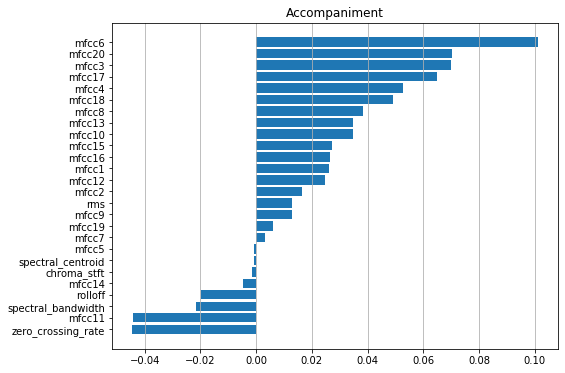

In [77]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_acc_svm, X_test, y_test,n_repeats = 10, random_state = rs)
imp_mean_acc = perm_importance.importances_mean
imp_std_acc = perm_importance.importances_std
features = X_train_song.columns.values[:-1]

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize = (8,6))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Accompaniment')
plt.grid(axis = 'x')
plt.savefig('acc.png');

# Vocals

In [16]:
df_voc = pd.read_csv('Data_Vocals_Only_30s_Overlapping.csv')
df_voc['song'] = df_voc['filename'].apply(lambda name: int(name[5:8]))
# df_voc = df_voc[df_voc['label'] != 3]
# display(df_voc.head())
features = df_voc.drop(columns = ['filename', 'label'])
# features.describe()

gss = GroupShuffleSplit(n_splits=1, train_size=ts, random_state=rs)

generator = gss.split(X = features, y = df_voc['label'], groups =  df_voc['song'])
split_data = generator.__next__()
# print(split_data)
X_train_song = features.iloc[split_data[0]]
df_voc_train = X_train_song
X_test_song = features.iloc[split_data[1]]
y_train = df_voc['label'].iloc[split_data[0]]
y_test = df_voc['label'].iloc[split_data[1]]

# display(X_train_song, X_test_song, y_train, y_test)

X_train = X_train_song.drop('song', axis = 1)
X_test = X_test_song.drop('song', axis = 1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_test_voc = pd.DataFrame(X_test, index=y_test.index)
#SVM Model
model_voc_svm = SVC(kernel = 'rbf', C = 5, probability = True)
model_voc_svm.fit(X_train, y_train)
y_pred = model_voc_svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred_voc_svm = y_pred
y_test_voc_svm = y_test
###############################################  Analyse Misclassifications

results = pd.DataFrame([])
results['y_test'] = y_test
results['y_pred'] = y_pred
results = pd.concat([results, X_test_song['song']], axis = 1)
results_grouped = results.groupby(['song', 'y_pred']).count()

incorrect = results[results['y_test'] != results['y_pred']]['song'].value_counts()
total = results['song'].value_counts().loc[results[results['y_test'] != results['y_pred']]['song'].value_counts().index]
percent_wrong = ((incorrect/total).sort_values(ascending = False) * 100).round(2)

misclassified = pd.DataFrame([])
misclassified['total'] = total
misclassified['incorrect'] = incorrect
misclassified['percent_wrong'] = percent_wrong
misclassified.sort_values(by = 'percent_wrong', ascending = False, inplace = True)
misclassified['1'] = results_grouped.xs(1, level = 1)
misclassified['2'] = results_grouped.xs(2, level = 1)
misclassified['3'] = results_grouped.xs(3, level = 1)
misclassified['real_genre'] = pd.Series(data = misclassified.index, index = misclassified.index).apply(lambda x: x//100)
misclassified['predicted_genre'] = misclassified[['1','2','3']].T.idxmax().astype(int)
misclassified.fillna(value = 0, inplace = True)
misclassified[['1','2','3']] = misclassified[['1','2','3']].astype(int)
misclassified['classification'] = misclassified['real_genre'] == misclassified['predicted_genre']
display(misclassified)
#index gives the song ID
mis_voc = misclassified.copy()
mis_voc_r = misclassified.copy()

misclassified_songs = misclassified.loc[misclassified['classification'] == False]
# display(misclassified_songs)

print('Total no. of songs in test data: ', X_test_song['song'].nunique())
print('No. of songs in which at least 1 excerpt is misclassified: ', len(misclassified.index.values))
print('No. of songs which are misclassified: ', len(misclassified_songs))

              precision    recall  f1-score   support

           1       0.55      0.76      0.64        88
           2       0.94      0.52      0.67       141
           3       0.48      0.64      0.55        86

    accuracy                           0.62       315
   macro avg       0.66      0.64      0.62       315
weighted avg       0.70      0.62      0.63       315

[[67  2 19]
 [26 74 41]
 [28  3 55]]


,total,incorrect,percent_wrong,1,2,3,real_genre,predicted_genre,classification
234,19,18,94.74,0,1,18,2,3,False
137,20,18,90.00,2,0,18,1,3,False
213,25,22,88.00,10,3,12,2,3,False
241,22,19,86.36,15,3,4,2,1,False
337,25,17,68.00,16,1,8,3,1,False
233,18,8,44.44,1,10,7,2,2,True
304,21,8,38.10,7,1,13,3,3,True
347,19,4,21.05,3,1,15,3,3,True
342,21,2,9.52,2,0,19,3,3,True
120,17,1,5.88,16,1,0,1,1,True


Total no. of songs in test data:  16
No. of songs in which at least 1 excerpt is misclassified:  12
No. of songs which are misclassified:  5


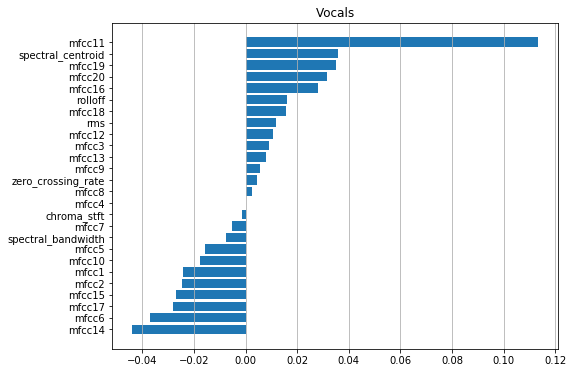

In [76]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_voc_svm, X_test, y_test, n_repeats = 10, random_state = rs)
imp_mean_voc = perm_importance.importances_mean
imp_std_voc = perm_importance.importances_std
features = X_train_song.columns.values[:-1]

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize = (8,6))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Vocals')
plt.grid(axis = 'x')
plt.savefig('voc.png');

# Mix

In [19]:
df_mix = pd.read_csv('Data_Overlapping_Excerpts_30s.csv')
df_mix['song'] = df_mix['filename'].apply(lambda name: int(name[5:8]))
# df_mix = df_mix[df_mix['label'] != 3]
# display(df_mix.head())
features = df_mix.drop(columns = ['filename', 'label'])
# features.describe()

gss = GroupShuffleSplit(n_splits=1, train_size=ts, random_state=rs)

generator = gss.split(X = features, y = df_mix['label'], groups =  df_mix['song'])
split_data = generator.__next__()
# print(split_data)
X_train_song = features.iloc[split_data[0]]
df_mix_train = X_train_song
X_test_song = features.iloc[split_data[1]]
y_train = df_mix['label'].iloc[split_data[0]]
y_test = df_mix['label'].iloc[split_data[1]]

# display(X_train_song, X_test_song, y_train, y_test)

X_train = X_train_song.drop('song', axis = 1)
X_test = X_test_song.drop('song', axis = 1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_test_mix = pd.DataFrame(X_test, index=y_test.index)

#SVM Model
model_mix_svm = SVC(kernel = 'rbf', C = 0.3, probability = True)
model_mix_svm.fit(X_train, y_train)
y_pred = model_mix_svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred_mix_svm = y_pred
y_test_mix_svm = y_test
###############################################  Analyse Misclassifications

results = pd.DataFrame([])
results['y_test'] = y_test
results['y_pred'] = y_pred
results = pd.concat([results, X_test_song['song']], axis = 1)
results_grouped = results.groupby(['song', 'y_pred']).count()

incorrect = results[results['y_test'] != results['y_pred']]['song'].value_counts()
total = results['song'].value_counts().loc[results[results['y_test'] != results['y_pred']]['song'].value_counts().index]
percent_wrong = ((incorrect/total).sort_values(ascending = False) * 100).round(2)

misclassified = pd.DataFrame([])
misclassified['total'] = total
misclassified['incorrect'] = incorrect
misclassified['percent_wrong'] = percent_wrong
misclassified.sort_values(by = 'percent_wrong', ascending = False, inplace = True)
misclassified['1'] = results_grouped.xs(1, level = 1)
misclassified['2'] = results_grouped.xs(2, level = 1)
misclassified['3'] = results_grouped.xs(3, level = 1)
misclassified['real_genre'] = pd.Series(data = misclassified.index, index = misclassified.index).apply(lambda x: x//100)
misclassified['predicted_genre'] = misclassified[['1','2','3']].T.idxmax().astype(int)
misclassified.fillna(value = 0, inplace = True)
misclassified[['1','2','3']] = misclassified[['1','2','3']].astype(int)
misclassified['classification'] = misclassified['real_genre'] == misclassified['predicted_genre']
display(misclassified)
#index gives the song ID
mis_mix = misclassified.copy()
mis_mix_r = misclassified.copy()

misclassified_songs = misclassified.loc[misclassified['classification'] == False]
# display(misclassified_songs)

print('Total no. of songs in test data: ', X_test_song['song'].nunique())
print('No. of songs in which at least 1 excerpt is misclassified: ', len(misclassified.index.values))
print('No. of songs which are misclassified: ', len(misclassified_songs))

              precision    recall  f1-score   support

           1       0.74      0.52      0.61        88
           2       0.66      0.59      0.62       141
           3       0.64      0.95      0.77        86

    accuracy                           0.67       315
   macro avg       0.68      0.69      0.67       315
weighted avg       0.68      0.67      0.66       315

[[46 42  0]
 [12 83 46]
 [ 4  0 82]]


,total,incorrect,percent_wrong,1,2,3,real_genre,predicted_genre,classification
213,25,25,100.00,5,0,20,2,3,False
120,17,16,94.12,1,16,0,1,2,False
234,19,15,78.95,2,4,13,2,3,False
241,22,17,77.27,4,5,13,2,3,False
137,20,14,70.00,6,14,0,1,2,False
119,15,9,60.00,6,9,0,1,2,False
304,21,3,14.29,3,0,18,3,3,True
146,18,2,11.11,16,2,0,1,1,True
116,18,1,5.56,17,1,0,1,1,True
233,18,1,5.56,1,17,0,2,2,True


Total no. of songs in test data:  16
No. of songs in which at least 1 excerpt is misclassified:  11
No. of songs which are misclassified:  6


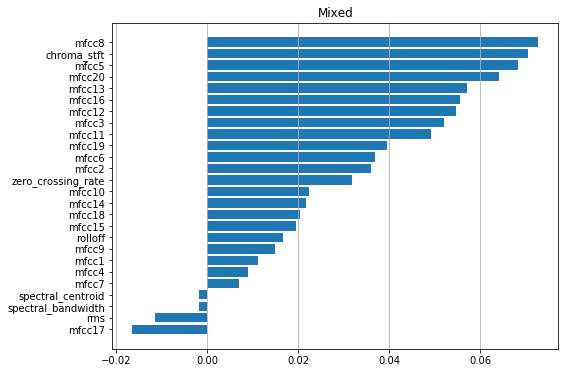

In [73]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_mix_svm, X_test, y_test, n_repeats = 10, random_state = rs)
imp_mean_mix = perm_importance.importances_mean
imp_std_mix = perm_importance.importances_std
features = X_train_song.columns.values[:-1]

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize = (8,6))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Mixed')
plt.grid(axis = 'x')
plt.savefig('mix.png');

In [ ]:
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1, figsize = (5,20))

ax1.

,imp_mean_acc,imp_std_acc,imp_mean_voc,imp_std_voc,imp_mean_mix,imp_std_mix,mean
chroma_stft,-0.002,0.009,-0.001,0.009,0.070,0.013,0.003
rms,0.013,0.009,0.012,0.009,-0.011,0.009,0.011
spectral_centroid,-0.001,0.011,0.036,0.010,-0.002,0.008,0.014
spectral_bandwidth,-0.022,0.008,-0.008,0.009,-0.002,0.003,-0.009
rolloff,-0.020,0.007,0.016,0.013,0.017,0.009,0.002
zero_crossing_rate,-0.044,0.018,0.004,0.004,0.032,0.008,-0.011
mfcc1,0.026,0.008,-0.024,0.016,0.011,0.005,0.002
mfcc2,0.017,0.011,-0.025,0.008,0.036,0.011,0.001
mfcc3,0.070,0.010,0.009,0.015,0.052,0.010,0.030
mfcc4,0.053,0.007,0.000,0.010,0.009,0.006,0.020


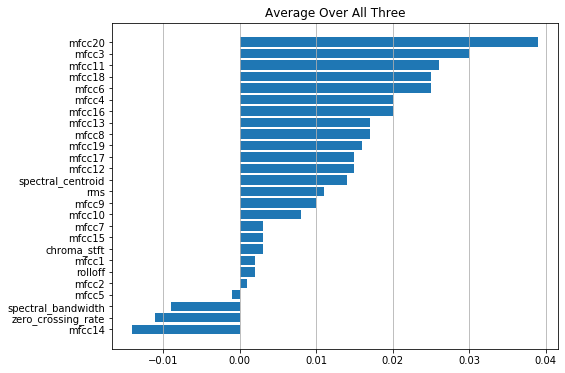

In [78]:
imp_df = pd.DataFrame(index = X_train_song.columns.values[:-1], 
                      columns = ["imp_mean_acc", "imp_std_acc", "imp_mean_voc",
                                 "imp_std_voc", "imp_mean_mix", "imp_std_mix"])
imp_df["imp_mean_acc"] = imp_mean_acc
imp_df["imp_std_acc"] = imp_std_acc
imp_df["imp_mean_voc"] = imp_mean_voc
imp_df["imp_std_voc"] = imp_std_voc
imp_df["imp_mean_mix"] = imp_mean_mix
imp_df["imp_std_mix"] = imp_std_mix
imp_df['mean'] = imp_df[["imp_mean_acc","imp_mean_voc", "imp_std_mix" ]].mean(axis = 1)
imp_df = imp_df.round(3)
display(imp_df)
plt.figure(figsize = (8,6))
sorted_idx = imp_df['mean'].argsort()
plt.barh(imp_df.index.values[sorted_idx],imp_df['mean'][sorted_idx])
plt.title('Average Over All Three')
plt.grid(axis = 'x')
plt.savefig('all3.png');

In [6]:
prob_acc = pd.DataFrame(model_acc_svm.predict_proba(X_test_acc).round(2), index = X_test_acc.index, columns = ["1_acc","2_acc","3_acc"])
prob_voc = pd.DataFrame(model_voc_svm.predict_proba(X_test_voc).round(2), index = X_test_voc.index, columns = ["1_voc","2_voc","3_voc"])
prob_mix = pd.DataFrame(model_mix_svm.predict_proba(X_test_mix).round(2), index = X_test_mix.index, columns = ["1_mix","2_mix","3_mix"])
prob_acc['pred_acc'] = y_pred_acc_svm
prob_voc['pred_voc'] = y_pred_voc_svm
prob_mix['pred_mix'] = y_pred_mix_svm 
prob = pd.concat([prob_acc, prob_voc, prob_mix], axis = 1)
prob['true'] = y_test.values
prob['song'] = X_test_song['song']
prob

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
288,0.05,0.04,0.91,3,0.95,0.03,0.03,1,0.78,0.18,0.04,1,1,116
289,0.05,0.07,0.88,3,0.98,0.02,0.00,1,0.73,0.26,0.01,1,1,116
290,0.38,0.09,0.52,3,0.67,0.33,0.00,1,0.73,0.27,0.01,1,1,116
291,0.36,0.06,0.58,3,0.89,0.11,0.00,1,0.68,0.31,0.01,1,1,116
292,0.65,0.07,0.28,1,0.96,0.04,0.00,1,0.78,0.21,0.01,1,1,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,0.03,0.11,0.86,3,0.00,0.00,1.00,3,0.03,0.01,0.97,3,3,347
2897,0.06,0.50,0.44,2,0.02,0.00,0.98,3,0.04,0.02,0.94,3,3,347
2898,0.04,0.76,0.20,2,0.05,0.00,0.95,3,0.04,0.02,0.94,3,3,347
2899,0.06,0.59,0.34,2,0.87,0.00,0.13,1,0.01,0.00,0.99,3,3,347


In [7]:
for i in prob['song'].unique():
    print("Song ID: ", i)
    print("Accompaniment")
    display(prob[prob['song'] == i]['pred_acc'].value_counts())
    print("Vocals")
    display(prob[prob['song'] == i]['pred_voc'].value_counts())
    print("Mix")
    display(prob[prob['song'] == i]['pred_mix'].value_counts())
    display(prob[prob['song'] == i])

Song ID:  116
Accompaniment


3    12
1     5
2     1
Name: pred_acc, dtype: int64

Vocals


1    17
2     1
Name: pred_voc, dtype: int64

Mix


1    17
2     1
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
288,0.05,0.04,0.91,3,0.95,0.03,0.03,1,0.78,0.18,0.04,1,1,116
289,0.05,0.07,0.88,3,0.98,0.02,0.00,1,0.73,0.26,0.01,1,1,116
290,0.38,0.09,0.52,3,0.67,0.33,0.00,1,0.73,0.27,0.01,1,1,116
291,0.36,0.06,0.58,3,0.89,0.11,0.00,1,0.68,0.31,0.01,1,1,116
292,0.65,0.07,0.28,1,0.96,0.04,0.00,1,0.78,0.21,0.01,1,1,116
293,0.60,0.05,0.35,1,0.97,0.03,0.00,1,0.76,0.23,0.01,1,1,116
294,0.47,0.05,0.47,3,0.99,0.01,0.00,1,0.71,0.29,0.01,1,1,116
295,0.35,0.03,0.62,3,0.99,0.01,0.00,1,0.63,0.37,0.01,2,1,116
296,0.35,0.01,0.64,3,0.99,0.00,0.00,1,0.70,0.29,0.01,1,1,116
297,0.41,0.03,0.56,3,0.99,0.01,0.00,1,0.78,0.21,0.01,1,1,116


Song ID:  119
Accompaniment


1    12
2     3
Name: pred_acc, dtype: int64

Vocals


1    15
Name: pred_voc, dtype: int64

Mix


2    9
1    6
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
343,0.45,0.33,0.22,2,1.00,0.0,0.0,1,0.70,0.28,0.02,1,1,119
344,0.76,0.17,0.07,1,1.00,0.0,0.0,1,0.67,0.31,0.01,1,1,119
345,0.82,0.13,0.04,1,1.00,0.0,0.0,1,0.70,0.28,0.01,1,1,119
346,0.81,0.13,0.06,1,1.00,0.0,0.0,1,0.65,0.34,0.01,1,1,119
347,0.81,0.11,0.08,1,1.00,0.0,0.0,1,0.66,0.33,0.01,1,1,119
348,0.77,0.18,0.05,1,1.00,0.0,0.0,1,0.49,0.50,0.01,2,1,119
349,0.71,0.26,0.03,1,1.00,0.0,0.0,1,0.47,0.53,0.01,2,1,119
350,0.71,0.26,0.03,1,1.00,0.0,0.0,1,0.34,0.66,0.01,2,1,119
351,0.56,0.34,0.10,2,1.00,0.0,0.0,1,0.28,0.71,0.01,2,1,119
352,0.60,0.23,0.17,1,1.00,0.0,0.0,1,0.15,0.84,0.00,2,1,119


Song ID:  120
Accompaniment


2    16
1     1
Name: pred_acc, dtype: int64

Vocals


1    16
2     1
Name: pred_voc, dtype: int64

Mix


2    16
1     1
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
358,0.18,0.82,0.00,2,0.99,0.01,0.0,1,0.25,0.75,0.00,2,1,120
359,0.23,0.76,0.01,2,0.96,0.04,0.0,1,0.37,0.63,0.00,2,1,120
360,0.21,0.78,0.01,2,0.99,0.01,0.0,1,0.39,0.61,0.00,2,1,120
361,0.06,0.91,0.03,2,0.99,0.01,0.0,1,0.29,0.70,0.00,2,1,120
362,0.27,0.73,0.00,2,1.00,0.00,0.0,1,0.26,0.74,0.00,2,1,120
363,0.27,0.70,0.03,2,0.69,0.31,0.0,1,0.21,0.79,0.00,2,1,120
364,0.24,0.75,0.01,2,0.93,0.07,0.0,1,0.29,0.70,0.00,2,1,120
365,0.27,0.72,0.02,2,0.89,0.11,0.0,1,0.19,0.80,0.00,2,1,120
366,0.43,0.57,0.00,2,0.99,0.01,0.0,1,0.26,0.74,0.00,2,1,120
367,0.71,0.29,0.00,1,0.76,0.24,0.0,1,0.23,0.77,0.00,2,1,120


Song ID:  137
Accompaniment


2    19
1     1
Name: pred_acc, dtype: int64

Vocals


3    18
1     2
Name: pred_voc, dtype: int64

Mix


2    14
1     6
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
692,0.55,0.18,0.27,1,0.01,0.00,0.99,3,0.95,0.01,0.04,1,1,137
693,0.36,0.41,0.23,2,0.73,0.09,0.18,1,0.73,0.18,0.08,1,1,137
694,0.14,0.76,0.09,2,0.04,0.02,0.94,3,0.58,0.41,0.01,2,1,137
695,0.32,0.61,0.08,2,0.00,0.00,1.00,3,0.42,0.57,0.01,2,1,137
696,0.33,0.57,0.10,2,0.00,0.00,1.00,3,0.29,0.70,0.01,2,1,137
697,0.19,0.77,0.05,2,0.01,0.00,0.99,3,0.36,0.64,0.01,2,1,137
698,0.06,0.89,0.06,2,0.02,0.00,0.98,3,0.57,0.42,0.02,2,1,137
699,0.11,0.79,0.10,2,0.00,0.00,1.00,3,0.26,0.74,0.00,2,1,137
700,0.13,0.81,0.06,2,0.01,0.00,0.99,3,0.30,0.70,0.00,2,1,137
701,0.32,0.58,0.10,2,0.15,0.00,0.85,3,0.42,0.58,0.00,2,1,137


Song ID:  146
Accompaniment


3    10
1     5
2     3
Name: pred_acc, dtype: int64

Vocals


1    17
3     1
Name: pred_voc, dtype: int64

Mix


1    16
2     2
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
851,0.33,0.35,0.32,2,0.92,0.01,0.07,1,0.99,0.00,0.00,1,1,146
852,0.21,0.71,0.08,2,0.97,0.02,0.01,1,0.96,0.04,0.00,1,1,146
853,0.34,0.29,0.37,2,1.00,0.00,0.00,1,0.97,0.03,0.00,1,1,146
854,0.37,0.02,0.62,3,0.99,0.00,0.01,1,0.89,0.11,0.01,1,1,146
855,0.24,0.01,0.75,3,0.99,0.00,0.01,1,0.81,0.18,0.01,1,1,146
856,0.13,0.00,0.87,3,0.97,0.00,0.03,1,0.59,0.41,0.00,2,1,146
857,0.16,0.00,0.84,3,0.97,0.00,0.03,1,0.51,0.49,0.00,2,1,146
858,0.11,0.01,0.88,3,0.24,0.00,0.75,3,0.71,0.28,0.00,1,1,146
859,0.33,0.01,0.66,3,0.93,0.01,0.06,1,0.84,0.15,0.01,1,1,146
860,0.44,0.02,0.54,3,0.96,0.01,0.03,1,0.95,0.05,0.01,1,1,146


Song ID:  203
Accompaniment


1    17
2     2
Name: pred_acc, dtype: int64

Vocals


2    19
Name: pred_voc, dtype: int64

Mix


2    19
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
1037,0.87,0.12,0.01,1,0.00,1.00,0.00,2,0.26,0.73,0.00,2,2,203
1038,0.92,0.07,0.01,1,0.00,1.00,0.00,2,0.53,0.46,0.00,2,2,203
1039,0.88,0.11,0.02,1,0.00,1.00,0.00,2,0.31,0.69,0.00,2,2,203
1040,0.84,0.15,0.01,1,0.00,1.00,0.00,2,0.17,0.83,0.00,2,2,203
1041,0.86,0.12,0.02,1,0.00,1.00,0.00,2,0.13,0.87,0.00,2,2,203
1042,0.83,0.15,0.02,1,0.00,1.00,0.00,2,0.19,0.81,0.00,2,2,203
1043,0.85,0.13,0.02,1,0.00,1.00,0.00,2,0.42,0.57,0.00,2,2,203
1044,0.80,0.19,0.01,1,0.00,1.00,0.00,2,0.39,0.60,0.00,2,2,203
1045,0.82,0.17,0.01,1,0.00,1.00,0.00,2,0.34,0.66,0.00,2,2,203
1046,0.71,0.27,0.02,1,0.00,1.00,0.00,2,0.21,0.79,0.00,2,2,203


Song ID:  213
Accompaniment


3    14
1     7
2     4
Name: pred_acc, dtype: int64

Vocals


3    12
1    10
2     3
Name: pred_voc, dtype: int64

Mix


3    20
1     5
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
1217,0.80,0.00,0.19,1,0.03,0.06,0.91,3,0.81,0.01,0.18,1,2,213
1218,0.87,0.01,0.12,1,0.00,0.00,0.99,3,0.72,0.03,0.25,1,2,213
1219,0.91,0.00,0.09,1,0.03,0.45,0.52,2,0.96,0.02,0.02,1,2,213
1220,0.96,0.00,0.03,1,0.55,0.41,0.04,2,0.93,0.03,0.04,1,2,213
1221,0.85,0.00,0.15,1,0.61,0.37,0.02,2,0.73,0.09,0.19,1,2,213
1222,0.04,0.06,0.91,3,0.74,0.09,0.18,1,0.10,0.09,0.81,3,2,213
1223,0.02,0.03,0.95,3,0.24,0.14,0.62,1,0.07,0.05,0.88,3,2,213
1224,0.01,0.01,0.98,3,0.77,0.06,0.17,1,0.04,0.02,0.93,3,2,213
1225,0.06,0.00,0.94,3,0.74,0.10,0.16,1,0.03,0.02,0.96,3,2,213
1226,0.03,0.05,0.93,3,0.41,0.27,0.33,1,0.02,0.01,0.97,3,2,213


Song ID:  233
Accompaniment


2    10
1     8
Name: pred_acc, dtype: int64

Vocals


2    10
3     7
1     1
Name: pred_voc, dtype: int64

Mix


2    17
1     1
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
1586,0.03,0.96,0.01,2,0.06,0.02,0.92,3,0.02,0.97,0.01,2,2,233
1587,0.18,0.78,0.04,2,0.02,0.66,0.31,2,0.01,0.99,0.00,2,2,233
1588,0.16,0.78,0.06,2,0.01,0.26,0.73,3,0.01,0.99,0.00,2,2,233
1589,0.13,0.80,0.06,2,0.00,0.16,0.83,3,0.00,0.98,0.02,2,2,233
1590,0.10,0.87,0.02,2,0.00,0.36,0.63,2,0.00,0.97,0.02,2,2,233
1591,0.51,0.34,0.15,1,0.01,0.97,0.02,2,0.04,0.91,0.05,2,2,233
1592,0.55,0.31,0.14,1,0.30,0.45,0.25,2,0.03,0.95,0.02,2,2,233
1593,0.40,0.40,0.20,1,0.19,0.57,0.24,2,0.04,0.94,0.02,2,2,233
1594,0.28,0.38,0.34,2,0.00,0.00,1.00,3,0.01,0.99,0.00,2,2,233
1595,0.32,0.39,0.29,1,0.00,0.00,1.00,3,0.01,0.98,0.01,2,2,233


Song ID:  234
Accompaniment


2    17
1     2
Name: pred_acc, dtype: int64

Vocals


3    18
2     1
Name: pred_voc, dtype: int64

Mix


3    13
2     4
1     2
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
1604,0.24,0.76,0.00,2,0.02,0.73,0.25,2,0.51,0.36,0.13,2,2,234
1605,0.08,0.91,0.00,2,0.00,0.00,1.00,3,0.15,0.39,0.46,3,2,234
1606,0.15,0.83,0.02,2,0.00,0.00,1.00,3,0.04,0.53,0.44,2,2,234
1607,0.23,0.72,0.06,2,0.00,0.00,1.00,3,0.03,0.12,0.84,3,2,234
1608,0.66,0.31,0.03,1,0.01,0.05,0.95,3,0.07,0.04,0.89,3,2,234
1609,0.44,0.45,0.10,2,0.08,0.14,0.78,3,0.40,0.09,0.51,3,2,234
1610,0.43,0.46,0.11,2,0.05,0.23,0.73,3,0.11,0.24,0.66,3,2,234
1611,0.12,0.74,0.14,2,0.21,0.14,0.65,3,0.07,0.23,0.71,3,2,234
1612,0.12,0.78,0.09,2,0.04,0.01,0.95,3,0.07,0.15,0.77,3,2,234
1613,0.21,0.59,0.20,2,0.05,0.02,0.93,3,0.06,0.04,0.90,3,2,234


Song ID:  241
Accompaniment


3    17
2     4
1     1
Name: pred_acc, dtype: int64

Vocals


1    15
3     4
2     3
Name: pred_voc, dtype: int64

Mix


3    13
2     5
1     4
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
1733,0.06,0.09,0.86,3,0.39,0.16,0.45,1,0.15,0.03,0.83,3,2,241
1734,0.01,0.02,0.97,3,0.95,0.01,0.04,1,0.12,0.08,0.81,3,2,241
1735,0.02,0.14,0.84,3,0.99,0.01,0.00,1,0.26,0.38,0.36,2,2,241
1736,0.01,0.03,0.96,3,0.99,0.01,0.00,1,0.08,0.31,0.61,3,2,241
1737,0.00,0.00,1.00,3,0.99,0.01,0.00,1,0.04,0.03,0.94,3,2,241
1738,0.01,0.00,0.99,3,0.71,0.21,0.08,1,0.03,0.00,0.97,3,2,241
1739,0.03,0.00,0.97,3,0.08,0.03,0.88,3,0.08,0.01,0.91,3,2,241
1740,0.01,0.00,0.99,3,0.03,0.00,0.97,3,0.01,0.01,0.98,3,2,241
1741,0.00,0.00,1.00,3,0.05,0.01,0.94,3,0.01,0.00,0.99,3,2,241
1742,0.00,0.01,0.99,3,0.07,0.01,0.92,3,0.01,0.00,0.98,3,2,241


Song ID:  242
Accompaniment


2    20
Name: pred_acc, dtype: int64

Vocals


2    20
Name: pred_voc, dtype: int64

Mix


2    20
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
1755,0.13,0.83,0.04,2,0.05,0.95,0.00,2,0.07,0.86,0.07,2,2,242
1756,0.02,0.92,0.07,2,0.00,0.99,0.00,2,0.05,0.95,0.01,2,2,242
1757,0.01,0.98,0.01,2,0.04,0.96,0.00,2,0.06,0.92,0.02,2,2,242
1758,0.07,0.90,0.03,2,0.07,0.93,0.00,2,0.09,0.89,0.03,2,2,242
1759,0.12,0.85,0.03,2,0.29,0.69,0.02,2,0.06,0.90,0.04,2,2,242
1760,0.03,0.96,0.02,2,0.01,0.99,0.00,2,0.02,0.98,0.01,2,2,242
1761,0.01,0.98,0.01,2,0.00,1.00,0.00,2,0.02,0.98,0.01,2,2,242
1762,0.02,0.98,0.01,2,0.00,1.00,0.00,2,0.02,0.96,0.01,2,2,242
1763,0.03,0.96,0.01,2,0.00,1.00,0.00,2,0.05,0.93,0.02,2,2,242
1764,0.07,0.92,0.01,2,0.00,1.00,0.00,2,0.03,0.95,0.01,2,2,242


Song ID:  253
Accompaniment


2    18
Name: pred_acc, dtype: int64

Vocals


2    18
Name: pred_voc, dtype: int64

Mix


2    18
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
1968,0.04,0.96,0.0,2,0.12,0.88,0.0,2,0.08,0.92,0.0,2,2,253
1969,0.10,0.90,0.0,2,0.45,0.55,0.0,2,0.02,0.98,0.0,2,2,253
1970,0.08,0.92,0.0,2,0.10,0.90,0.0,2,0.01,0.99,0.0,2,2,253
1971,0.07,0.93,0.0,2,0.14,0.86,0.0,2,0.03,0.97,0.0,2,2,253
1972,0.05,0.95,0.0,2,0.19,0.81,0.0,2,0.04,0.96,0.0,2,2,253
1973,0.05,0.95,0.0,2,0.28,0.72,0.0,2,0.07,0.93,0.0,2,2,253
1974,0.09,0.91,0.0,2,0.05,0.95,0.0,2,0.05,0.95,0.0,2,2,253
1975,0.08,0.92,0.0,2,0.02,0.98,0.0,2,0.03,0.97,0.0,2,2,253
1976,0.06,0.94,0.0,2,0.12,0.88,0.0,2,0.02,0.98,0.0,2,2,253
1977,0.06,0.94,0.0,2,0.11,0.89,0.0,2,0.04,0.96,0.0,2,2,253


Song ID:  304
Accompaniment


3    12
2     5
1     4
Name: pred_acc, dtype: int64

Vocals


3    13
1     7
2     1
Name: pred_voc, dtype: int64

Mix


3    18
1     3
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
2047,0.01,0.90,0.09,2,0.05,0.06,0.90,3,0.11,0.04,0.85,3,3,304
2048,0.05,0.03,0.91,3,0.43,0.41,0.17,2,0.31,0.07,0.62,3,3,304
2049,0.87,0.06,0.07,1,0.68,0.02,0.30,1,0.48,0.09,0.43,1,3,304
2050,0.91,0.05,0.04,1,0.97,0.01,0.02,1,0.67,0.07,0.26,1,3,304
2051,0.77,0.06,0.17,1,0.75,0.02,0.23,1,0.61,0.06,0.33,1,3,304
2052,0.03,0.02,0.95,3,0.62,0.06,0.32,1,0.27,0.04,0.69,3,3,304
2053,0.02,0.08,0.90,3,0.00,0.00,1.00,3,0.02,0.02,0.96,3,3,304
2054,0.03,0.01,0.96,3,0.01,0.00,0.99,3,0.04,0.04,0.92,3,3,304
2055,0.29,0.02,0.69,3,0.00,0.00,1.00,3,0.06,0.06,0.89,3,3,304
2056,0.05,0.00,0.94,3,0.41,0.09,0.50,3,0.04,0.03,0.93,3,3,304


Song ID:  337
Accompaniment


3    25
Name: pred_acc, dtype: int64

Vocals


1    16
3     8
2     1
Name: pred_voc, dtype: int64

Mix


3    25
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
2678,0.00,0.00,1.00,3,1.00,0.00,0.00,1,0.16,0.00,0.84,3,3,337
2679,0.00,0.00,1.00,3,1.00,0.00,0.00,1,0.14,0.01,0.85,3,3,337
2680,0.00,0.00,1.00,3,0.99,0.00,0.00,1,0.14,0.29,0.57,3,3,337
2681,0.01,0.00,0.99,3,0.63,0.03,0.34,1,0.03,0.46,0.51,3,3,337
2682,0.00,0.00,1.00,3,0.46,0.00,0.53,3,0.02,0.18,0.80,3,3,337
2683,0.00,0.00,1.00,3,0.72,0.00,0.28,1,0.00,0.00,0.99,3,3,337
2684,0.00,0.00,1.00,3,0.99,0.00,0.00,1,0.02,0.00,0.98,3,3,337
2685,0.00,0.00,1.00,3,0.88,0.09,0.03,1,0.07,0.00,0.93,3,3,337
2686,0.00,0.00,1.00,3,0.56,0.34,0.11,1,0.05,0.05,0.91,3,3,337
2687,0.00,0.00,1.00,3,0.52,0.01,0.47,3,0.01,0.06,0.92,3,3,337


Song ID:  342
Accompaniment


3    20
1     1
Name: pred_acc, dtype: int64

Vocals


3    19
1     2
Name: pred_voc, dtype: int64

Mix


3    21
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
2780,0.01,0.0,0.99,3,0.35,0.06,0.59,3,0.0,0.0,1.0,3,3,342
2781,0.00,0.0,1.00,3,0.55,0.17,0.29,1,0.0,0.0,1.0,3,3,342
2782,0.00,0.0,1.00,3,0.15,0.00,0.85,3,0.0,0.0,1.0,3,3,342
2783,0.00,0.0,1.00,3,0.01,0.00,0.99,3,0.0,0.0,1.0,3,3,342
2784,0.02,0.0,0.98,3,0.11,0.20,0.69,1,0.0,0.0,1.0,3,3,342
2785,0.13,0.0,0.87,3,0.01,0.00,0.99,3,0.0,0.0,1.0,3,3,342
2786,0.20,0.0,0.80,3,0.14,0.00,0.86,3,0.0,0.0,1.0,3,3,342
2787,0.10,0.0,0.90,3,0.01,0.00,0.99,3,0.0,0.0,1.0,3,3,342
2788,0.05,0.0,0.95,3,0.00,0.00,1.00,3,0.0,0.0,1.0,3,3,342
2789,0.08,0.0,0.92,3,0.01,0.00,0.99,3,0.0,0.0,1.0,3,3,342


Song ID:  347
Accompaniment


3    9
2    8
1    2
Name: pred_acc, dtype: int64

Vocals


3    15
1     3
2     1
Name: pred_voc, dtype: int64

Mix


3    18
1     1
Name: pred_mix, dtype: int64

,1_acc,2_acc,3_acc,pred_acc,1_voc,2_voc,3_voc,pred_voc,1_mix,2_mix,3_mix,pred_mix,true,song
2882,0.40,0.31,0.29,1,0.03,0.00,0.97,3,0.78,0.06,0.16,1,3,347
2883,0.22,0.66,0.12,2,0.00,0.00,1.00,3,0.22,0.01,0.77,3,3,347
2884,0.57,0.27,0.17,1,0.00,0.01,0.99,3,0.03,0.00,0.97,3,3,347
2885,0.06,0.01,0.93,3,0.00,0.00,1.00,3,0.00,0.00,1.00,3,3,347
2886,0.03,0.01,0.96,3,0.43,0.01,0.56,3,0.00,0.00,1.00,3,3,347
2887,0.00,0.01,0.99,3,0.14,0.23,0.62,1,0.00,0.00,1.00,3,3,347
2888,0.00,0.00,0.99,3,0.12,0.30,0.58,2,0.00,0.00,1.00,3,3,347
2889,0.00,0.00,1.00,3,0.27,0.00,0.73,3,0.00,0.00,0.99,3,3,347
2890,0.03,0.04,0.93,3,0.01,0.00,0.99,3,0.00,0.00,0.99,3,3,347
2891,0.07,0.10,0.83,3,0.00,0.00,1.00,3,0.01,0.00,0.99,3,3,347


In [8]:
# for df in [df_acc, df_voc, df_mix]:
#     display(df[df['label'] == 1].describe())
#     display(df[df['label'] == 2].describe())
#     display(df[df['label'] == 3].describe())
print('Bhaktigeet Acc')
display(df_acc_train[df_acc_train['song']//100 == 1].describe())
print("Bhavgeet Acc")
display(df_acc_train[df_acc_train['song']//100 == 2].describe())
print("Lavani Acc")
display(df_acc_train[df_acc_train['song']//100 == 3].describe())
print('Bhaktigeet Voc')
display(df_voc_train[df_voc_train['song']//100 == 1].describe())
print("Bhavgeet Voc")
display(df_voc_train[df_voc_train['song']//100 == 2].describe())
print("Lavani Voc")
display(df_voc_train[df_voc_train['song']//100 == 3].describe())

Bhaktigeet Acc


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
count,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,...,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,0.384744,0.080268,1963.570907,2058.276225,3954.262446,0.062962,-296.654676,159.088532,-12.559410,31.018654,...,-3.832972,-1.056370,-1.520163,-4.536125,3.276259,-5.310010,0.960729,-0.166520,-2.181914,126.690710
std,0.068674,0.038378,707.444772,654.788680,1599.507431,0.027633,70.387145,27.823474,34.607033,32.856822,...,7.457869,7.585562,7.606813,6.642838,7.157308,6.684291,5.655689,5.969615,5.333248,15.552743
min,0.236099,0.008195,529.362864,598.563180,806.528456,0.019514,-525.936300,81.538030,-111.675210,-63.959850,...,-26.686958,-23.600130,-23.437004,-22.565018,-15.030545,-21.110300,-13.590624,-17.653976,-17.772488,101.000000
25%,0.328464,0.051062,1351.589921,1581.555700,2448.901858,0.037431,-332.875990,140.054885,-28.773414,7.070630,...,-8.860090,-6.292868,-7.019927,-9.217205,-1.296920,-10.411893,-3.127826,-4.747895,-5.624461,112.000000
50%,0.387853,0.074014,2052.191363,2172.191669,4111.875136,0.063018,-289.321560,157.344830,-9.956871,40.792065,...,-4.319668,-1.180489,-2.291094,-4.929885,2.737918,-5.368746,0.848280,-0.355772,-2.366592,127.000000
75%,0.429274,0.107158,2425.801164,2558.561379,5093.960864,0.083509,-245.401680,177.798685,6.511003,53.899156,...,1.279617,5.143668,4.043652,-0.382059,7.835242,-0.531235,4.730710,4.298705,0.848520,140.000000
max,0.594642,0.198676,3842.008536,3524.988793,7797.919514,0.139777,-155.725250,233.084100,83.836720,119.337150,...,19.102090,17.868969,18.010050,18.929573,21.677540,13.578753,17.533163,15.540267,15.504420,153.000000


Bhavgeet Acc


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,...,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000
mean,0.382524,0.074857,1507.656120,1648.615063,2890.385561,0.040760,-311.772174,171.467721,-8.269171,12.425751,...,-2.315663,-2.628871,-1.217768,-3.157997,-0.442469,-3.900112,-2.210042,-1.910829,-1.965709,226.844418
std,0.076798,0.039538,578.630024,529.725573,1169.628429,0.015138,65.410482,27.537179,30.714752,31.788924,...,5.741947,4.738305,5.066029,4.676483,5.108400,4.438563,4.340119,3.981144,4.373530,15.152441
min,0.244426,0.003302,495.422992,602.509264,855.269828,0.012560,-564.688000,62.454550,-79.567360,-77.559730,...,-20.185156,-15.797467,-22.922047,-14.732525,-16.151575,-16.041433,-13.948940,-15.783787,-15.017079,201.000000
25%,0.321929,0.046342,1162.539586,1193.285019,2148.937006,0.029815,-352.501415,155.925770,-31.125804,-10.076891,...,-5.742632,-5.828035,-4.253970,-6.425584,-4.364410,-7.056850,-4.890841,-4.479117,-5.250699,215.000000
50%,0.369561,0.066938,1502.740465,1667.817904,2741.479256,0.040505,-306.377670,171.504240,-12.294166,13.734492,...,-2.120186,-2.926992,-1.657687,-3.813950,-0.583654,-3.839500,-2.554343,-2.012902,-1.784567,226.000000
75%,0.436287,0.096012,1770.588107,2055.164170,3611.321913,0.049312,-272.625565,191.930412,12.820730,38.418143,...,1.189461,0.262475,1.793285,-0.214185,2.659968,-0.810251,0.193154,0.380511,1.246530,239.000000
max,0.631592,0.197855,5061.086747,3568.218706,8680.722509,0.097055,-128.262440,229.654880,73.591270,78.012980,...,18.636927,15.106468,14.072004,13.006239,15.226801,9.338807,18.392687,19.986519,13.855037,252.000000


Lavani Acc


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
count,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,...,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000
mean,0.408123,0.085990,1931.150736,2054.762265,3964.862727,0.054134,-281.511626,160.455482,-22.371125,39.151215,...,-1.596870,0.561503,2.207176,-4.576792,0.868673,-2.988313,0.374149,-0.133474,-1.444556,323.567182
std,0.061703,0.045452,601.476484,548.968025,1402.439502,0.018888,73.500930,25.916968,34.769940,26.120068,...,4.866859,5.186632,5.002727,4.377249,5.794461,4.997949,5.644145,4.289805,4.140065,13.322844
min,0.241776,0.009490,522.618469,657.043609,664.445982,0.013017,-551.774960,77.155045,-85.964890,-42.357838,...,-19.504381,-14.936009,-11.747280,-16.596634,-14.328517,-18.294186,-15.244492,-12.615456,-12.684940,301.000000
25%,0.362370,0.048589,1612.002087,1780.844137,3253.838658,0.041034,-321.705780,144.856660,-45.392680,26.303364,...,-5.166934,-3.111876,-1.085390,-7.630665,-3.547781,-6.336820,-3.555644,-3.044521,-4.496849,312.000000
50%,0.396780,0.078757,1980.807794,2092.167454,4076.550350,0.053661,-273.800720,161.185330,-29.529205,45.544150,...,-1.378416,0.071654,2.175153,-4.049436,1.157390,-2.942445,0.723178,-0.019964,-1.347022,323.000000
75%,0.449073,0.111653,2260.057523,2419.383602,4768.054502,0.066450,-231.254960,176.277900,-6.228768,57.364080,...,1.799110,3.860825,5.275339,-1.157810,5.449727,0.343149,4.414072,2.970301,1.312744,334.000000
max,0.638663,0.264242,5702.658746,3834.833091,10379.662236,0.143165,-102.445470,233.617110,92.519750,86.858010,...,10.421366,14.505374,19.771772,5.471999,15.650540,13.004700,16.903980,13.148137,11.792355,348.000000


Bhaktigeet Voc


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
count,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,...,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,0.244803,0.128370,2152.980560,1642.100100,3573.096955,0.067472,-335.467304,117.412554,-50.074537,-6.151021,...,-9.549093,-12.190352,-5.948317,-6.222944,-4.820916,-2.589235,-0.656413,-2.793702,-0.200231,126.690710
std,0.034562,0.082031,1043.248436,562.682565,1617.320678,0.038455,77.068467,40.957891,38.329105,27.922975,...,8.273874,8.917216,7.341620,8.586847,8.908303,9.868283,7.330303,8.572988,10.467161,15.552743
min,0.140819,0.000256,483.955586,491.411809,677.987567,0.015316,-990.129600,-33.297516,-139.643050,-85.720116,...,-28.611576,-46.642887,-28.320270,-27.371145,-27.366383,-27.280676,-18.441458,-30.945900,-25.111555,101.000000
25%,0.219835,0.081576,1333.893387,1212.373675,2177.845164,0.040089,-380.493475,90.496010,-80.590273,-24.891096,...,-15.241659,-18.387539,-11.213617,-11.832704,-10.942285,-10.002853,-6.004541,-8.475616,-8.173724,112.000000
50%,0.244737,0.109772,2053.586106,1704.584245,3514.470415,0.059398,-327.629640,119.543550,-51.178936,-2.974927,...,-10.592601,-12.290226,-6.274349,-7.369782,-5.823030,-3.665007,-1.066855,-4.305775,-0.658651,127.000000
75%,0.269352,0.146452,2656.991106,1980.129897,4524.264309,0.082117,-285.540400,143.076080,-21.108619,14.368451,...,-4.784180,-5.969463,-0.321069,-1.133581,-0.233275,3.835466,3.403334,2.162217,7.493579,140.000000
max,0.348519,0.544730,8062.314823,3396.780484,10929.292245,0.322462,-183.642870,226.153520,70.476590,57.965225,...,13.676114,17.664341,17.751852,29.723316,32.126537,37.239002,24.554522,28.018698,36.593742,153.000000


Bhavgeet Voc


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,...,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000
mean,0.235480,0.129740,1793.509116,1509.998462,3059.610220,0.051025,-360.831123,115.086366,-23.396088,-13.936432,...,-13.686730,-9.916864,-8.782781,-8.882073,-3.815008,-3.778530,-0.703364,-0.729399,0.073305,226.844418
std,0.038484,0.089749,865.361365,671.381139,1594.579712,0.023563,74.291702,33.707088,26.842543,29.519830,...,6.385956,8.281772,6.623901,6.776692,8.122562,10.012028,7.246781,7.504932,9.859477,15.152441
min,0.132179,0.013725,588.887396,587.648146,898.519567,0.016272,-560.571900,14.245089,-101.917370,-88.721080,...,-29.789764,-28.783875,-28.033870,-27.784050,-22.540735,-22.717210,-19.472792,-18.815893,-22.475346,201.000000
25%,0.205139,0.076127,1116.248029,973.435740,1818.099423,0.034337,-415.993890,92.066233,-40.603332,-35.748317,...,-18.247104,-15.134060,-12.974978,-13.485621,-9.384714,-11.398862,-5.426072,-6.640885,-7.839985,215.000000
50%,0.230346,0.106967,1555.806095,1235.305846,2540.763803,0.045597,-369.091660,114.057395,-24.246426,-15.765263,...,-14.141272,-9.713776,-8.245265,-9.117976,-4.348065,-5.116288,-1.426241,-2.049923,0.485857,226.000000
75%,0.263075,0.154422,2307.176262,2042.372799,4073.158703,0.061542,-312.807330,140.752098,-6.461169,5.302402,...,-10.001232,-4.337961,-4.792928,-5.365064,1.324600,2.055211,3.245477,5.374881,7.702668,239.000000
max,0.342736,0.524315,6141.741389,3339.242862,8955.554180,0.176419,-178.480150,196.546200,45.746105,65.800950,...,14.298009,20.006184,17.380693,22.810701,25.701431,30.836056,26.899126,22.256207,29.684849,252.000000


Lavani Voc


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
count,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,...,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000
mean,0.236905,0.091095,2864.068023,2017.054340,4772.645893,0.090948,-376.207412,85.309689,-59.012957,-2.872620,...,-12.638973,-14.982100,-5.670070,-5.649914,0.270254,1.060867,5.096264,2.205733,6.653415,323.567182
std,0.027236,0.058070,1234.483214,626.393149,1816.052237,0.049626,98.960360,37.581704,30.475436,27.578779,...,8.567010,7.477354,6.436125,8.695375,8.404440,8.953609,7.858403,7.492840,8.647769,13.322844
min,0.112670,0.000643,719.402788,610.341487,913.786141,0.022336,-867.068400,-45.849040,-141.702470,-73.265335,...,-40.061750,-37.227192,-25.656637,-29.014513,-22.841255,-27.346952,-15.508210,-17.426570,-21.548632,301.000000
25%,0.218566,0.050419,2142.460504,1564.248507,3606.744857,0.058616,-442.664180,63.114720,-79.229330,-21.316164,...,-18.124165,-19.716540,-10.057102,-11.407248,-5.569449,-4.651615,-0.378675,-2.971075,0.672443,312.000000
50%,0.235667,0.075833,2668.072048,2080.291677,4728.496407,0.079124,-378.434230,85.795370,-60.340040,3.148430,...,-12.569011,-15.265277,-5.986514,-5.495559,0.184361,0.250025,5.176933,2.137702,6.614023,323.000000
75%,0.253556,0.126072,3384.049513,2472.928378,5900.980984,0.101898,-296.003900,111.874756,-40.738950,16.962284,...,-6.393973,-10.011888,-1.789959,-0.411053,5.572534,6.139562,10.874117,7.554035,11.648622,334.000000
max,0.360485,0.324445,8687.617773,3845.414718,11498.780468,0.324365,-164.229490,182.586900,41.463894,84.293130,...,10.101325,7.645588,17.045687,21.636724,27.263605,26.624153,28.383385,24.870390,36.579945,348.000000


In [9]:
series = prob[prob['pred_voc'] != prob['true']].index.values
wrong_excerpts = df_voc.loc[series]
wrong_excerpts[['pred_voc','1_voc', '2_voc', '3_voc']] = prob[['pred_voc','1_voc', '2_voc', '3_voc']].loc[series]
wrong_excerpts

,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc17,mfcc18,mfcc19,mfcc20,label,song,pred_voc,1_voc,2_voc,3_voc
302,0302_116_140_30s,0.250238,0.111502,1111.095844,983.018139,1783.189217,0.037865,-375.58347,155.296970,19.779774,...,-5.167270,-1.911165,-4.683550,-10.619015,1,116,2,0.45,0.55,0.00
374,0374_120_160_30s,0.218906,0.057944,911.183946,899.386241,1651.906678,0.025449,-439.03880,139.370600,4.906540,...,-7.876293,-2.463919,-5.764795,-10.285879,1,120,2,0.46,0.54,0.00
692,0692_137_000_30s,0.224591,0.077937,3724.033581,2389.367468,6037.821823,0.108401,-413.04623,43.168320,-43.482292,...,10.424621,7.140746,6.944981,13.212193,1,137,3,0.01,0.00,0.99
694,0694_137_020_30s,0.212033,0.096484,2506.714903,1627.987364,3797.743702,0.089866,-384.98163,57.411404,-56.284927,...,6.301865,6.925105,12.724400,22.660906,1,137,3,0.04,0.02,0.94
695,0695_137_030_30s,0.195741,0.060032,2811.453642,1590.334599,3961.167714,0.110473,-458.92023,33.021385,-37.324436,...,-1.100265,1.352127,9.608990,13.250315,1,137,3,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,2784_342_040_30s,0.229873,0.075570,3399.383983,1817.273453,5038.102869,0.131056,-393.45758,64.321304,-70.993860,...,-6.365425,-4.664472,11.235614,14.103273,3,342,1,0.11,0.20,0.69
2887,2887_347_050_30s,0.169539,0.022395,3550.770249,2000.794173,5447.092062,0.100247,-519.15050,48.020450,-42.810997,...,8.207649,2.378161,10.863771,22.776375,3,347,1,0.14,0.23,0.62
2888,2888_347_060_30s,0.128175,0.018729,2817.388581,1630.921994,4331.082144,0.079377,-540.99580,29.680876,-33.524967,...,1.771567,-0.843518,1.610846,6.108417,3,347,2,0.12,0.30,0.58
2892,2892_347_100_30s,0.217616,0.057117,2180.733744,1885.829848,3873.343245,0.059489,-390.23355,87.446220,-77.421630,...,8.207217,11.007854,19.964470,29.831835,3,347,1,0.87,0.00,0.13


In [10]:
for song in wrong_excerpts['song'].unique():
    print("Song ID: ", song)
    display(wrong_excerpts[wrong_excerpts['song'] == song][['spectral_centroid', "rolloff",'spectral_bandwidth',
                                                            'zero_crossing_rate', 'pred_voc','1_voc', '2_voc', '3_voc']])

Song ID:  116


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
302,1111.095844,1783.189217,983.018139,0.037865,2,0.45,0.55,0.0


Song ID:  120


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
374,911.183946,1651.906678,899.386241,0.025449,2,0.46,0.54,0.0


Song ID:  137


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
692,3724.033581,6037.821823,2389.367468,0.108401,3,0.01,0.00,0.99
694,2506.714903,3797.743702,1627.987364,0.089866,3,0.04,0.02,0.94
695,2811.453642,3961.167714,1590.334599,0.110473,3,0.00,0.00,1.00
696,3023.076163,4327.515499,1655.954986,0.114198,3,0.00,0.00,1.00
697,2730.034447,4320.648874,1787.390350,0.093454,3,0.01,0.00,0.99
698,2874.056351,4558.947433,1849.263561,0.096012,3,0.02,0.00,0.98
699,3424.038411,5398.942353,2237.295884,0.108240,3,0.00,0.00,1.00
700,3119.748495,4440.239817,1746.290704,0.115034,3,0.01,0.00,0.99
701,2901.729728,4484.814548,1839.280819,0.094929,3,0.15,0.00,0.85
702,2524.561282,4013.925728,1670.398375,0.083723,3,0.07,0.00,0.93


Song ID:  146


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
858,2323.420955,3710.110899,1945.57286,0.076563,3,0.24,0.0,0.75


Song ID:  213


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
1217,2146.760046,3876.009896,2033.532735,0.054717,3,0.03,0.06,0.91
1218,2357.474214,4232.899404,2235.583440,0.059849,3,0.00,0.00,0.99
1222,2917.398967,5113.827411,2340.180018,0.086833,1,0.74,0.09,0.18
1223,2980.270260,5244.718286,2303.742505,0.090572,1,0.24,0.14,0.62
1224,3457.174825,5884.647750,2400.605697,0.113592,1,0.77,0.06,0.17
1225,3361.406855,5549.283111,2321.236779,0.106728,1,0.74,0.10,0.16
1226,3259.616128,5364.050898,2300.599484,0.103151,1,0.41,0.27,0.33
1227,2792.859720,4896.312059,2349.529967,0.076004,1,0.80,0.05,0.15
1228,2984.918385,5254.334894,2480.442260,0.082834,1,0.76,0.06,0.17
1229,3028.103394,5075.452643,2312.067856,0.094870,1,0.26,0.21,0.53


Song ID:  233


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
1586,2213.404569,3444.562505,1491.502478,0.061245,3,0.06,0.02,0.92
1588,1322.533467,2070.654146,897.978144,0.049448,3,0.01,0.26,0.73
1589,1232.057620,2006.262868,889.592315,0.043522,3,0.00,0.16,0.83
1594,1159.013769,1800.080782,799.001995,0.042087,3,0.00,0.00,1.00
1595,1234.025115,1870.055359,839.357924,0.044333,3,0.00,0.00,1.00
1596,1304.715515,2004.962876,846.233487,0.047349,1,0.71,0.25,0.04
1599,1186.142037,1885.938596,836.118274,0.041260,3,0.01,0.12,0.87
1600,1257.740456,1981.138020,902.936940,0.042586,3,0.00,0.26,0.74


Song ID:  234


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
1605,2068.019374,3418.504329,1609.597139,0.063646,3,0.00,0.00,1.00
1606,1671.382139,2433.885283,1037.884869,0.066128,3,0.00,0.00,1.00
1607,1816.052690,2809.074681,1155.214945,0.060827,3,0.00,0.00,1.00
1608,2242.966303,3758.935604,1576.556972,0.054734,3,0.01,0.05,0.95
1609,2330.009310,3766.218893,1842.340577,0.058001,3,0.08,0.14,0.78
1610,2552.547024,4139.991633,2070.034825,0.073139,3,0.05,0.23,0.73
1611,2278.057836,3607.544852,1569.091631,0.075358,3,0.21,0.14,0.65
1612,2109.805800,3237.630422,1345.229869,0.076938,3,0.04,0.01,0.95
1613,1912.594262,2835.174523,1153.231082,0.077687,3,0.05,0.02,0.93
1614,2245.635837,3798.993695,1569.716647,0.065602,3,0.01,0.00,0.99


Song ID:  241


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
1733,2155.323509,3628.044728,2087.459491,0.045596,1,0.39,0.16,0.45
1734,3266.105882,5522.274941,2651.866837,0.091962,1,0.95,0.01,0.04
1735,2214.216988,4326.148840,2287.745046,0.051295,1,0.99,0.01,0.00
1736,1906.267995,3702.144280,1960.299790,0.050460,1,0.99,0.01,0.00
1737,2491.463891,4663.705133,2175.695378,0.069125,1,0.99,0.01,0.00
1738,4069.428647,6392.011348,2567.378046,0.132135,1,0.71,0.21,0.08
1739,4489.061193,6703.126134,2844.807377,0.155660,3,0.08,0.03,0.88
1740,5035.396178,7011.174271,2583.133542,0.199392,3,0.03,0.00,0.97
1741,4637.883644,7099.990401,3074.455452,0.165337,3,0.05,0.01,0.94
1742,4259.695425,7092.465446,3049.261421,0.140128,3,0.07,0.01,0.92


Song ID:  304


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
2048,2174.712697,3321.754914,1598.720911,0.068407,2,0.43,0.41,0.17
2049,1824.961237,3220.463860,1651.705573,0.042794,1,0.68,0.02,0.30
2050,1781.444346,3086.781335,1575.701284,0.044987,1,0.97,0.01,0.02
2051,1839.913418,3311.213311,1816.518490,0.045562,1,0.75,0.02,0.23
2052,1647.988404,2779.549859,1473.407284,0.050564,1,0.62,0.06,0.32
2063,1463.745235,2307.902711,997.474282,0.052329,1,0.62,0.01,0.38
2064,1464.141529,2253.394707,979.164545,0.054018,1,0.79,0.01,0.20
2065,1458.334941,2278.044558,1075.237640,0.051385,1,0.56,0.02,0.42


Song ID:  337


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
2678,1603.412363,2969.565377,1520.495637,0.048255,1,1.00,0.00,0.00
2679,1368.007275,2554.184555,1491.164503,0.034985,1,1.00,0.00,0.00
2680,1484.257526,2721.200212,1518.945314,0.038194,1,0.99,0.00,0.00
2681,1552.798835,2811.224668,1496.354190,0.039454,1,0.63,0.03,0.34
2683,1727.865002,3115.939492,1560.095257,0.047320,1,0.72,0.00,0.28
2684,1913.862714,3126.472761,1481.304157,0.060792,1,0.99,0.00,0.00
2685,1919.380939,3159.005898,1556.350896,0.060276,1,0.88,0.09,0.03
2686,1716.334016,2882.840901,1460.745395,0.052183,1,0.56,0.34,0.11
2688,1576.526204,2860.799368,1430.606473,0.040970,1,0.92,0.02,0.07
2689,1978.105247,3302.921694,1478.943922,0.064718,1,0.79,0.01,0.21


Song ID:  342


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
2781,3561.603229,4855.245641,1683.963647,0.139657,1,0.55,0.17,0.29
2784,3399.383983,5038.102869,1817.273453,0.131056,1,0.11,0.20,0.69


Song ID:  347


,spectral_centroid,rolloff,spectral_bandwidth,zero_crossing_rate,pred_voc,1_voc,2_voc,3_voc
2887,3550.770249,5447.092062,2000.794173,0.100247,1,0.14,0.23,0.62
2888,2817.388581,4331.082144,1630.921994,0.079377,2,0.12,0.30,0.58
2892,2180.733744,3873.343245,1885.829848,0.059489,1,0.87,0.00,0.13
2899,1984.755108,3475.362318,1735.762468,0.056478,1,0.87,0.00,0.13


In [11]:
df_voc_train

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,song
0,0.234174,0.095797,2310.939808,1718.008773,4034.408938,0.044440,-392.88310,117.823975,-24.459517,-5.217364,...,-2.182153,-18.449778,-12.256162,-9.508302,-11.793986,2.573142,9.379346,5.178037,8.990522,101
1,0.196099,0.118519,1201.799389,1156.922425,2195.478391,0.034022,-347.83180,150.288570,-26.830942,-2.234331,...,-2.334434,-21.020067,-14.651427,-12.042171,-16.949558,-1.462655,8.410458,3.754071,7.717248,101
2,0.196948,0.103039,1250.272935,1147.800143,2168.620220,0.039276,-367.68048,142.187000,-17.270302,1.248205,...,0.586545,-20.849257,-16.156946,-13.101976,-19.423360,-5.587361,4.874255,2.254395,8.233912,101
3,0.201260,0.101993,1396.179540,1242.243238,2404.168796,0.041400,-374.53674,127.153790,-34.283380,-0.593061,...,-1.166865,-22.754747,-16.540123,-13.180845,-19.667768,-5.391531,4.173785,3.076560,10.287269,101
4,0.210180,0.092534,1463.924711,1342.560066,2680.917122,0.039778,-383.83417,119.633965,-36.821476,3.101813,...,-5.199173,-23.084833,-16.914898,-14.581727,-17.881657,-1.106758,5.974480,4.076707,13.844455,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,0.240460,0.158089,2859.517731,2179.461406,4772.629474,0.092122,-283.56198,73.927666,-97.270330,-13.742679,...,-11.159506,-19.429873,7.102962,2.614171,12.756203,26.624153,19.630833,14.780997,10.184732,348
2909,0.240209,0.169399,2686.203803,2178.793909,4592.722228,0.085095,-272.47192,70.012410,-104.572296,-12.505115,...,-9.441752,-14.758773,13.226865,3.238662,11.471391,22.979400,15.512204,10.308926,8.062786,348
2910,0.241646,0.145180,2802.058100,2228.744253,4786.729389,0.089281,-287.43225,65.777534,-97.184360,-5.126170,...,-13.416801,-16.576807,9.991431,-8.093960,-0.083028,10.573737,2.003164,0.782448,9.552856,348
2911,0.258466,0.135416,2810.301562,2144.334300,4726.704752,0.092738,-272.32390,76.376820,-94.573030,-2.848988,...,-19.522655,-24.056290,1.820354,-16.616970,-9.386765,4.596702,-3.631616,-3.226228,13.399295,348
